In [1]:
import random

import matplotlib.pyplot as plt
from functools import partial
import networkx as nx

from gerrychain import MarkovChain
from gerrychain.constraints import (
    Validator,
    single_flip_contiguous,
    within_percent_of_ideal_population,
)
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain.updaters import Tally, cut_edges
from gerrychain.partition import Partition
from gerrychain.proposals import recom
from numpy import linalg as LA

In [54]:
def spectral_cut(G):
    nlist = list(G.nodes())
    n = len(nlist)
    NLM = (nx.normalized_laplacian_matrix(G)).todense()
    # LM = (nx.laplacian_matrix(G)).todense()
    NLMva, NLMve = LA.eigh(NLM)
    NFv = NLMve[:, 1]
    xNFv = [NFv.item(x) for x in range(n)]
    node_color = [xNFv[x] > 0 for x in range(n)]

    clusters = {nlist[x]: node_color[x] for x in range(n)}

    return clusters


def propose_spectral_merge(partition):
    edge = random.choice(tuple(partition["cut_edges"]))
    et = [partition.assignment[edge[0]], partition.assignment[edge[1]]]
    sgn = []
    for n in partition.graph.nodes():
        if partition.assignment[n] in et:
            sgn.append(n)

    sgraph = nx.subgraph(partition.graph, sgn)

    edd = {0: et[0], 1: et[1]}


    clusters = spectral_cut(sgraph)
    flips = {}
    for val in clusters.keys():
        flips[val] = edd[clusters[val]]

    return partition.flip(flips)

In [40]:
gn = 4
k = 4
ns = 550
p = 0.5

graph = nx.grid_graph([k * gn, k * gn])

for n in graph.nodes():
    graph.nodes[n]["population"] = 1

    if random.random() < p:
        graph.nodes[n]["pink"] = 1
        graph.nodes[n]["purple"] = 0
    else:
        graph.nodes[n]["pink"] = 0
        graph.nodes[n]["purple"] = 1
    if 0 in n or k * gn - 1 in n:
        graph.nodes[n]["boundary_node"] = True
        graph.nodes[n]["boundary_perim"] = 1

    else:
        graph.nodes[n]["boundary_node"] = False


In [41]:
cddict = {x: int(x[0] / gn) for x in graph.nodes()}
pos = {x: x for x in graph.nodes()}

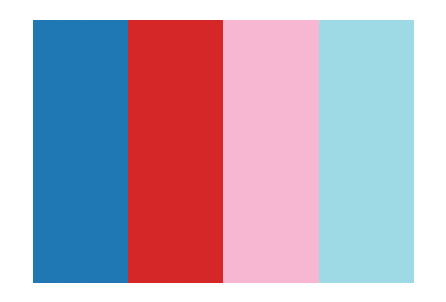

In [42]:
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[cddict[x] for x in graph.nodes()],
    node_size=ns,
    node_shape="s",
    cmap="tab20",
)

In [43]:
updaters = {
    "population": Tally("population"),
    "cut_edges": cut_edges,
    # "Pink-Purple": Election("Pink-Purple", {"Pink":"pink","Purple":"purple"})
}

In [44]:
squiggle_partition = Partition(graph, assignment=cddict, updaters=updaters)

In [50]:
popbound = within_percent_of_ideal_population(squiggle_partition, 0.1)

In [51]:
squiggle_chain = MarkovChain(
    propose_random_flip,
    Validator([single_flip_contiguous, popbound]),
    accept=always_accept,
    initial_state=squiggle_partition,
    total_steps=100_000,
)


for part2 in squiggle_chain:
    pass


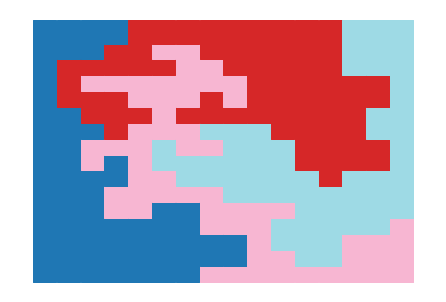

In [52]:
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[part2.assignment[x] for x in graph.nodes()],
    node_size=ns,
    node_shape="s",
    cmap="tab20",
)

In [56]:
final_partition = Partition(graph, assignment=part2.assignment, updaters=updaters)

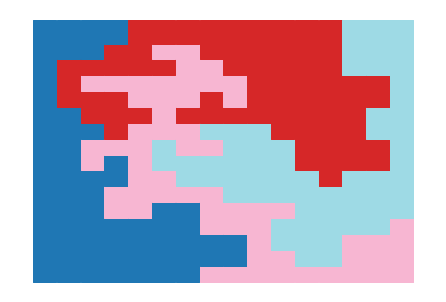

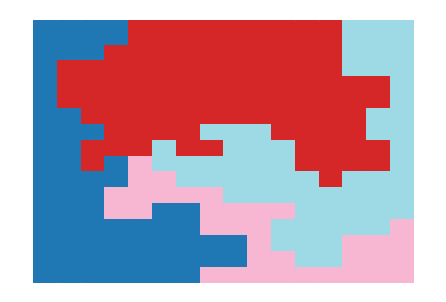

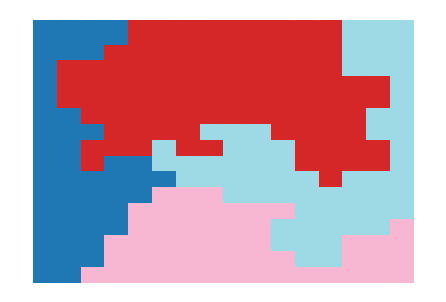

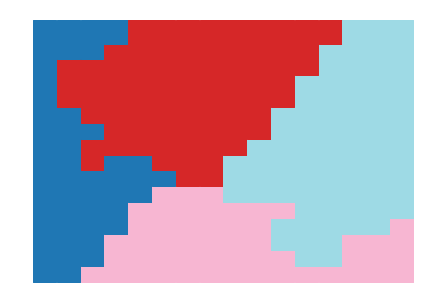

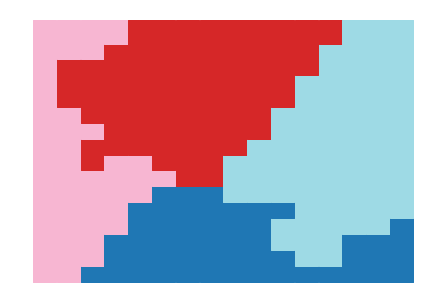

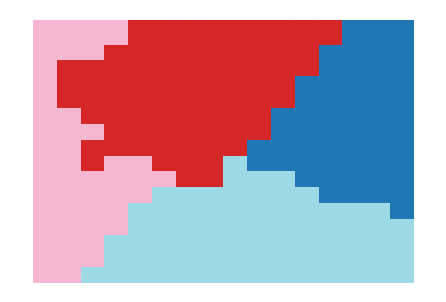

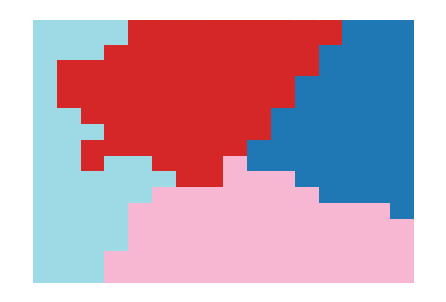

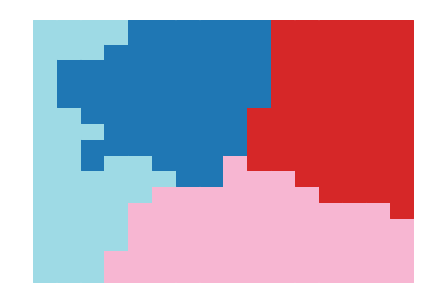

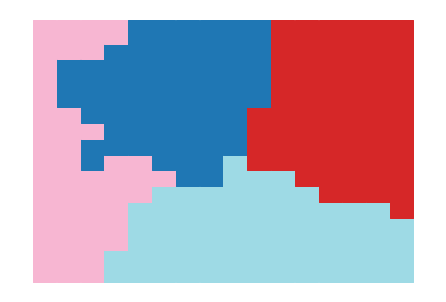

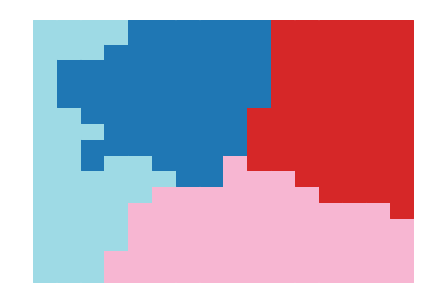

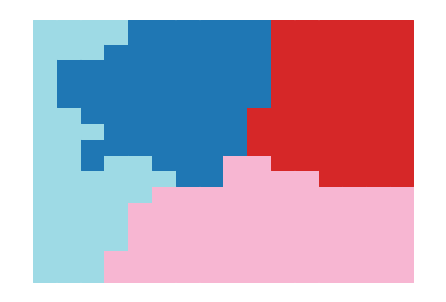

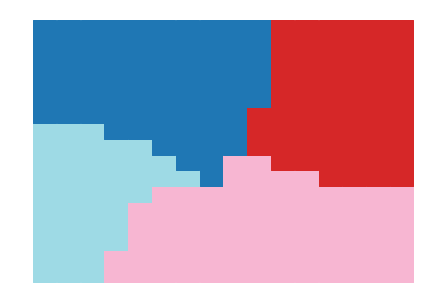

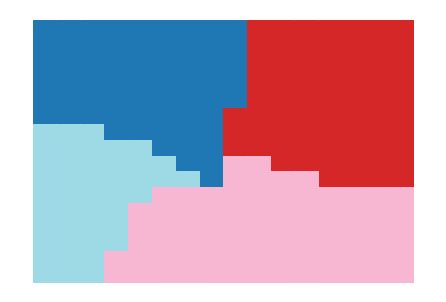

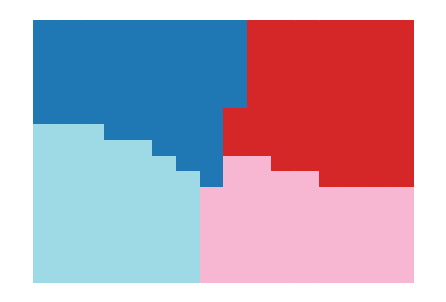

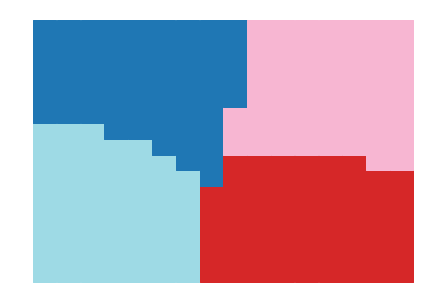

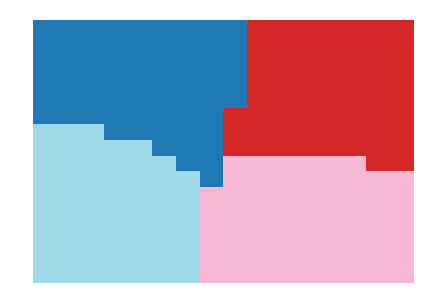

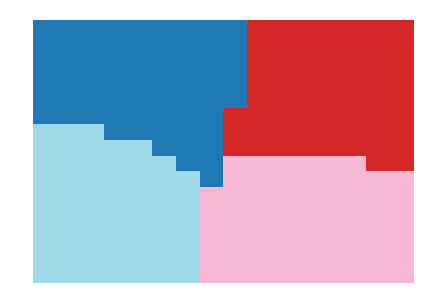

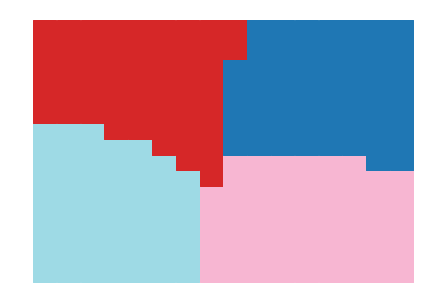

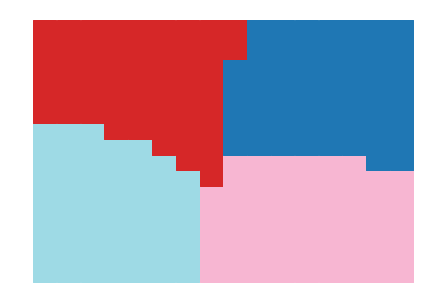

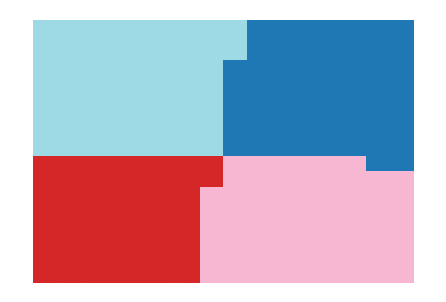

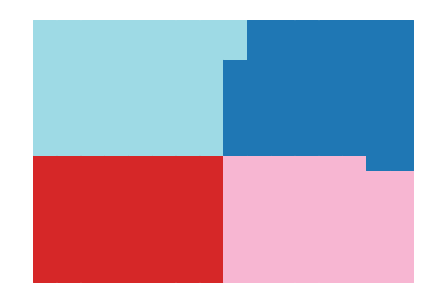

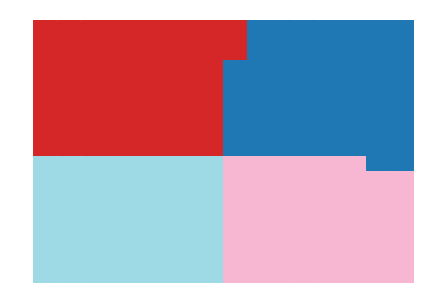

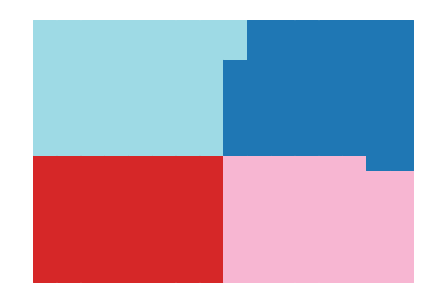

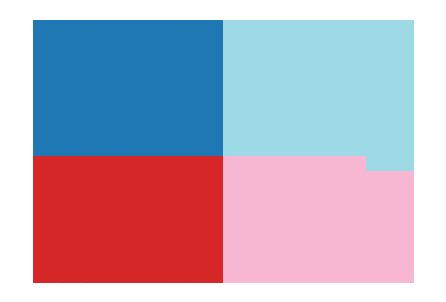

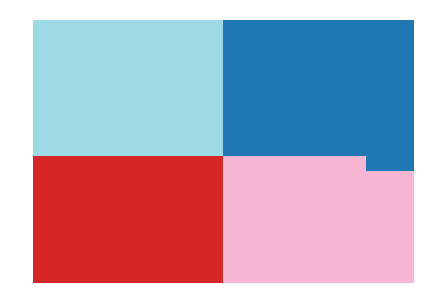

In [57]:
final_chain = MarkovChain(
    propose_spectral_merge,
    Validator([]),
    accept=always_accept,
    initial_state=final_partition,
    total_steps=25,
)


for part3 in final_chain:
    plt.figure()
    nx.draw(
        graph,
        pos,
        node_color=[part3.assignment[x] for x in graph.nodes()],
        node_size=ns,
        node_shape="s",
        cmap="tab20",
    )
    plt.show()
    plt.close()



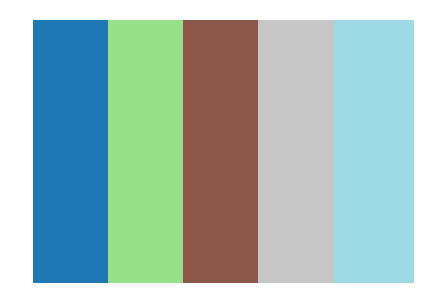

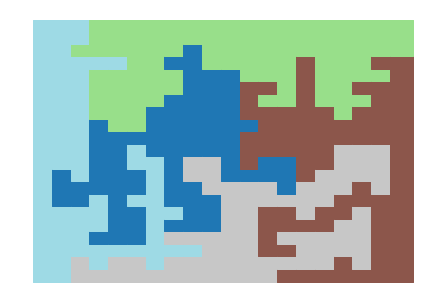

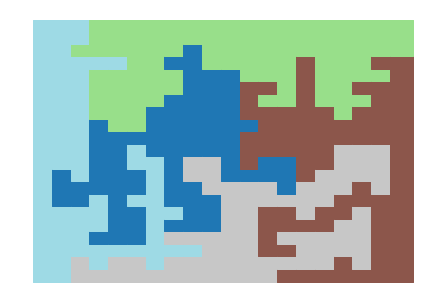

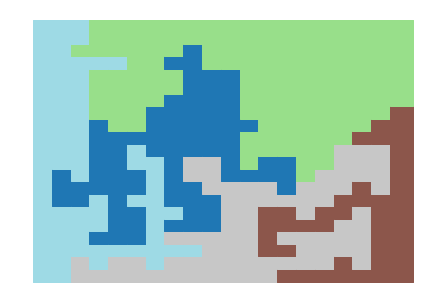

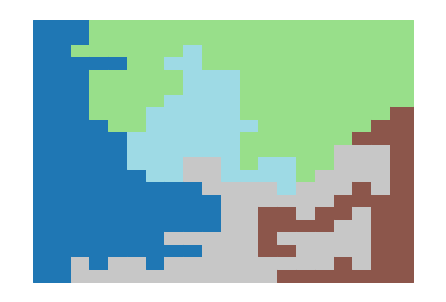

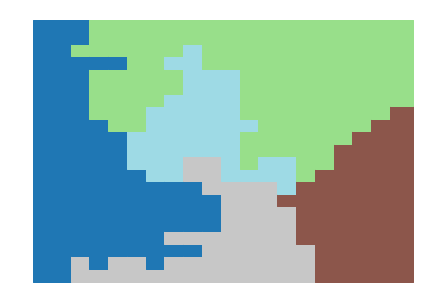

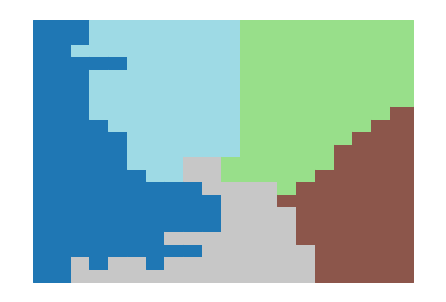

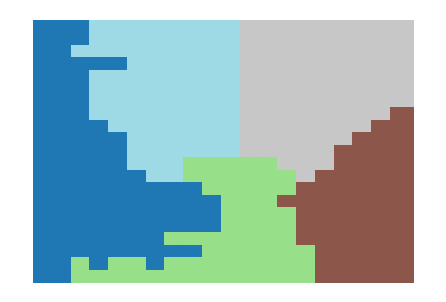

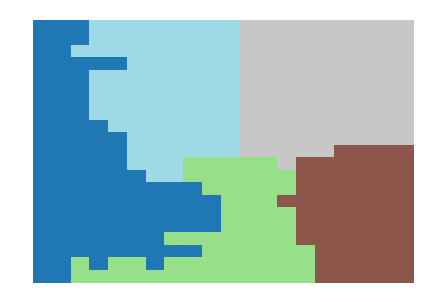

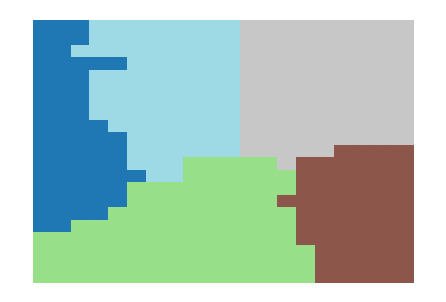

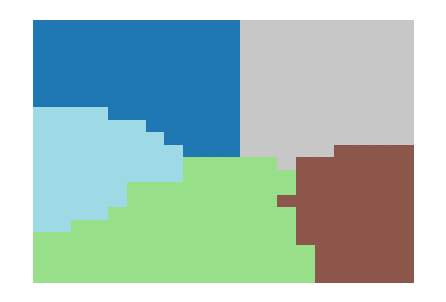

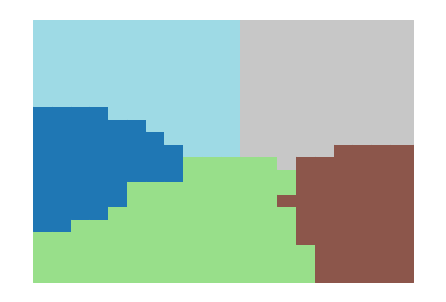

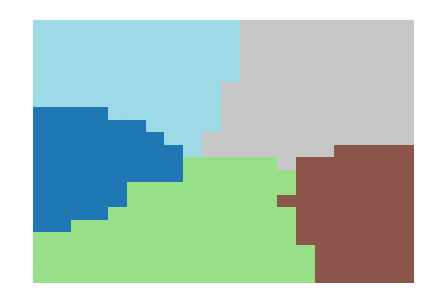

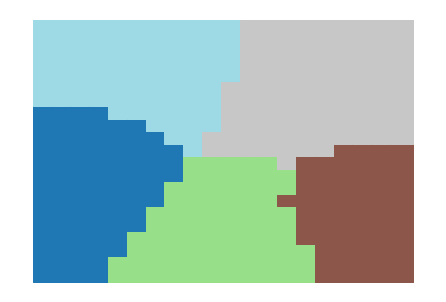

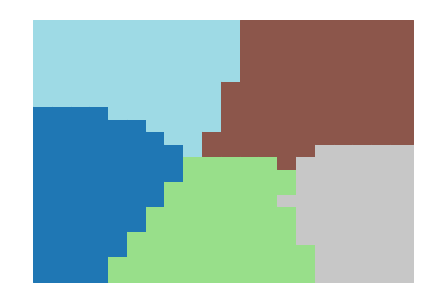

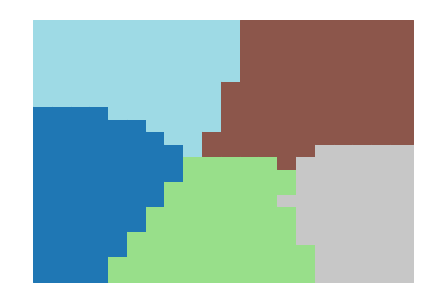

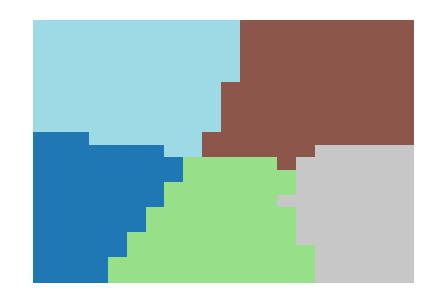

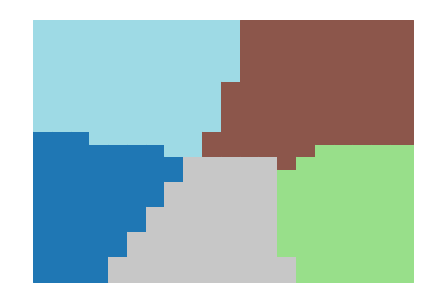

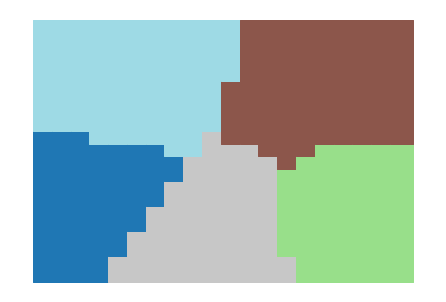

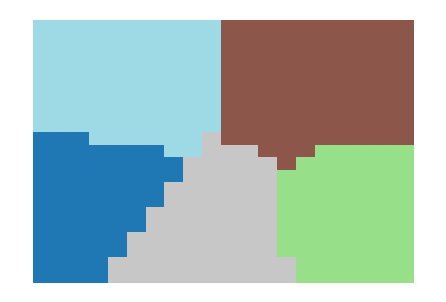

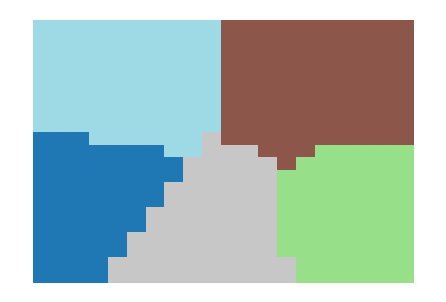

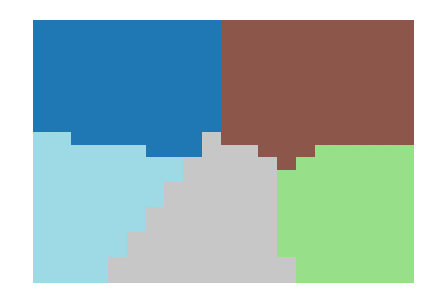

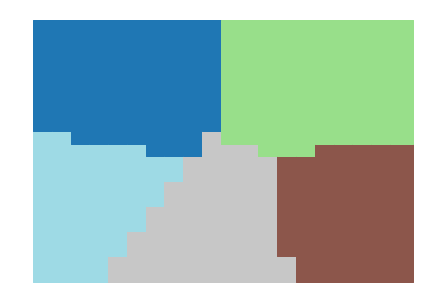

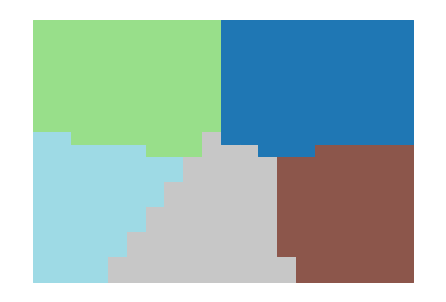

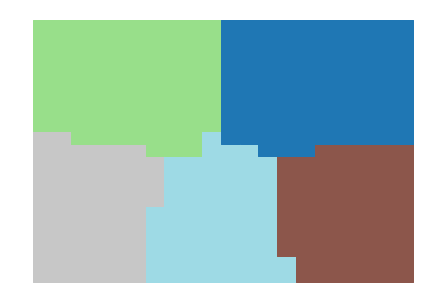

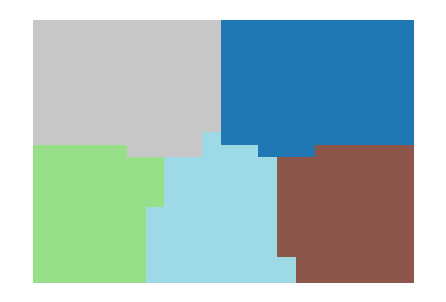

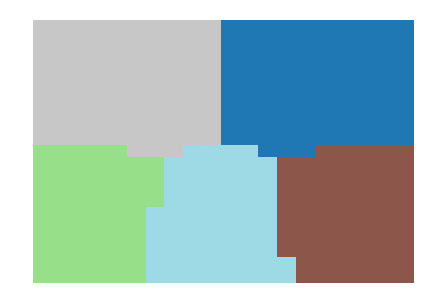

In [61]:
gn = 4
k = 5
ns = 550
p = 0.5

graph = nx.grid_graph([k * gn, k * gn])

for n in graph.nodes():
    graph.nodes[n]["population"] = 1

    if random.random() < p:
        graph.nodes[n]["pink"] = 1
        graph.nodes[n]["purple"] = 0
    else:
        graph.nodes[n]["pink"] = 0
        graph.nodes[n]["purple"] = 1
    if 0 in n or k * gn - 1 in n:
        graph.nodes[n]["boundary_node"] = True
        graph.nodes[n]["boundary_perim"] = 1

    else:
        graph.nodes[n]["boundary_node"] = False
        
cddict = {x: int(x[0] / 4) for x in graph.nodes()}
pos = {x: x for x in graph.nodes()}

nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[cddict[x] for x in graph.nodes()],
    node_size=ns,
    node_shape="s",
    cmap="tab20",
)

plt.show()

updaters = {
    "population": Tally("population"),
    "cut_edges": cut_edges,
    # "Pink-Purple": Election("Pink-Purple", {"Pink":"pink","Purple":"purple"})
}


squiggle_partition = Partition(graph, assignment=cddict, updaters=updaters)

popbound = within_percent_of_ideal_population(squiggle_partition, 0.1)

squiggle_chain = MarkovChain(
    propose_random_flip,
    Validator([single_flip_contiguous, popbound]),
    accept=always_accept,
    initial_state=squiggle_partition,
    total_steps=1_000_000,
)


for part2 in squiggle_chain:
    pass

nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[part2.assignment[x] for x in graph.nodes()],
    node_size=ns,
    node_shape="s",
    cmap="tab20",
)

final_partition = Partition(graph, assignment=part2.assignment, updaters=updaters)

final_chain = MarkovChain(
    propose_spectral_merge,
    Validator([]),
    accept=always_accept,
    initial_state=final_partition,
    total_steps=25,
)


for part3 in final_chain:
    plt.figure()
    nx.draw(
        graph,
        pos,
        node_color=[part3.assignment[x] for x in graph.nodes()],
        node_size=ns,
        node_shape="s",
        cmap="tab20",
    )
    plt.show()
    plt.close()

